# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import re
import copy
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import avg, stddev, split, udf, isnull, first, col, format_number, rand
from pyspark.sql.functions import min as fmin
from pyspark.sql.functions import max as fmax
from pyspark.sql.types import IntegerType, FloatType
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier,RandomForestClassifier, LinearSVC
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from statsmodels.stats.proportion import proportions_ztest

%matplotlib inline

In [2]:
# create a Spark session
spark = SparkSession.builder.appName('Sparkify_local').getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
# load dataset from .json

df = spark.read.json('mini_sparkify_event_data.json')
df.show(1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
only showi

In [4]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
df.count()

286500

In [6]:
# Clean dataset : drop any rows that have a missing userId or sessionId, either with Nan value or empty string. 
df_clean = df.dropna(how = "any", subset = ["userId", "sessionId"])
df_clean = df_clean.filter(df.userId != "")
df_clean.count()

278154

In [7]:
#  explore useId feature
df_clean.select(["userId"]).dropDuplicates().describe().show()
df_clean.count()

+-------+------------------+
|summary|            userId|
+-------+------------------+
|  count|               225|
|   mean|65391.013333333336|
| stddev|105396.47791907164|
|    min|                10|
|    max|                99|
+-------+------------------+



278154

In [8]:
# add time to see the time clear
get_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df_clean = df_clean.withColumn("time", get_time(df.ts))

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [9]:
df_clean.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', time='2018-10-01 00:01:57')]

In [10]:
# Try sparksql : create a temporary view to perform SQL operations
df_clean.createOrReplaceTempView("Sparkify_local_cleaned")

In [11]:
# get gender distribution

gender_count = spark.sql('''
        SELECT gender,COUNT(DISTINCT userId) AS user_counts
        FROM Sparkify_local_cleaned
        GROUP BY gender
        ORDER BY user_counts DESC
''')
gender_count.show()


+------+-----------+
|gender|user_counts|
+------+-----------+
|     M|        121|
|     F|        104|
+------+-----------+



Gender distribution looks quite balanced with 121 Male Users and 104 Femal users

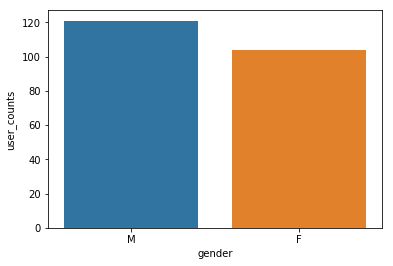

In [12]:
sns.barplot(x='gender',y='user_counts',data=gender_count.toPandas());

In [13]:
# Get users counted in different page categories

spark.sql('''
        SELECT page,COUNT(DISTINCT userId) AS user_counts
        FROM Sparkify_local_cleaned
        GROUP BY page
        ORDER BY page
''').show()

+--------------------+-----------+
|                page|user_counts|
+--------------------+-----------+
|               About|        155|
|          Add Friend|        206|
|     Add to Playlist|        215|
|              Cancel|         52|
|Cancellation Conf...|         52|
|           Downgrade|        154|
|               Error|        117|
|                Help|        192|
|                Home|        223|
|              Logout|        213|
|            NextSong|        225|
|         Roll Advert|        207|
|       Save Settings|        132|
|            Settings|        195|
|    Submit Downgrade|         49|
|      Submit Upgrade|        131|
|         Thumbs Down|        203|
|           Thumbs Up|        220|
|             Upgrade|        168|
+--------------------+-----------+



206 users add friend, 52 users cancelled, 49 users submitted downgrade, 131 users submitted upgrad, 203 users thumbs down, 220 users thumbs up

In [14]:
# get length information

length_data = spark.sql('''
        SELECT length
        FROM Sparkify_local_cleaned
''')

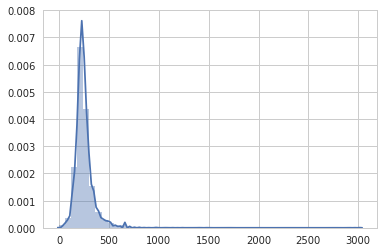

In [15]:
#set seaborn style
sns.set(style="whitegrid")
sns.distplot(length_data.toPandas().dropna());

In [16]:
# get user account level information

spark.sql('''
        SELECT level,COUNT(DISTINCT userId) AS user_counts
        FROM Sparkify_local_cleaned
        GROUP BY level
        ORDER BY user_counts DESC
''').show()

+-----+-----------+
|level|user_counts|
+-----+-----------+
| free|        195|
| paid|        165|
+-----+-----------+



There are 195 free and 165 paid account in this dataset.

In [17]:
# get location information

location_count = spark.sql('''
        SELECT location,COUNT(DISTINCT userId) AS user_counts
        FROM Sparkify_local_cleaned
        GROUP BY location
        ORDER BY user_counts DESC
''').toPandas()

In [18]:
#split city and state
location_count = location_count.join(location_count['location'].str.split(',',expand=True).rename(columns={0:'city',1:'state'})).drop('location',axis=1)

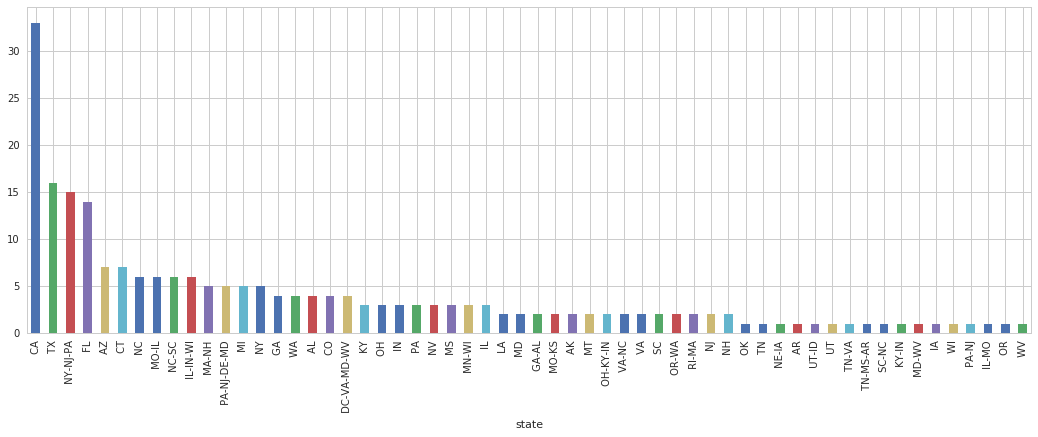

In [19]:
# display how many users (normalized value) at each state

location_count.groupby('state')['user_counts'].sum().sort_values(ascending=False).plot(kind='bar',figsize=(18,6));

Los Angeles and New York are top cities which have the largest user count, and California is the top state has the largest user count.

In [20]:
#  Display the userAgent popularity

spark.sql('''
        SELECT userAgent,COUNT(DISTINCT userId) AS user_counts
        FROM Sparkify_local_cleaned
        GROUP BY userAgent
        ORDER BY user_counts DESC
''').show()

+--------------------+-----------+
|           userAgent|user_counts|
+--------------------+-----------+
|"Mozilla/5.0 (Win...|         24|
|Mozilla/5.0 (Wind...|         18|
|"Mozilla/5.0 (Mac...|         16|
|"Mozilla/5.0 (Mac...|         12|
|"Mozilla/5.0 (Mac...|         12|
|"Mozilla/5.0 (Mac...|         10|
|"Mozilla/5.0 (Win...|         10|
|Mozilla/5.0 (Maci...|          9|
|"Mozilla/5.0 (iPh...|          8|
|"Mozilla/5.0 (Mac...|          7|
|"Mozilla/5.0 (Win...|          7|
|Mozilla/5.0 (Wind...|          7|
|"Mozilla/5.0 (Win...|          5|
|"Mozilla/5.0 (iPh...|          4|
|"Mozilla/5.0 (X11...|          4|
|Mozilla/5.0 (Wind...|          4|
|Mozilla/5.0 (X11;...|          4|
|"Mozilla/5.0 (Win...|          4|
|"Mozilla/5.0 (Win...|          4|
|"Mozilla/5.0 (Win...|          4|
+--------------------+-----------+
only showing top 20 rows



In [21]:
# Get the userAgent information

userAgent_count = spark.sql('''
        SELECT userAgent,COUNT(DISTINCT userId) AS user_counts
        FROM Sparkify_local_cleaned
        GROUP BY userAgent
        ORDER BY user_counts DESC
''').toPandas()

In [22]:
def get_browser(x):
    if 'Firefox' in x:
        return 'Firefox'
    elif 'Safari' in x:
        if 'Chrome' in x:
            return 'Chrome'
        else:
            return 'Safari'
    elif 'Trident' in x:
        return 'IE'
    else:
        return np.NaN

In [23]:
# get browser features from userAgent information

userAgent_count['browser'] = userAgent_count['userAgent'].apply(get_browser)

In [24]:
# create dictionary for platforms

platform_dict = {'compatible': 'Windows',  'iPad': 'iPad',  'iPhone': 'iPhone',  
          'Macintosh': 'Mac',  'Windows NT 5.1': 'Windows','Windows NT 6.0': 'Windows', 'Windows NT 6.1': 'Windows',  
          'Windows NT 6.2': 'Windows',  'Windows NT 6.3': 'Windows', 'X11': 'Linux'}

In [25]:
# Get platform features from userAgent information

userAgent_count['platform'] = userAgent_count['userAgent'].str.extract(r'\(([^\)]*)\)')[0].str.split(';').str[0].map(platform_dict)

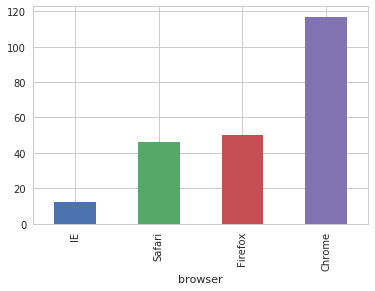

In [26]:
# Display browser distribution

userAgent_count.groupby('browser')['user_counts'].sum().sort_values().plot(kind='bar');


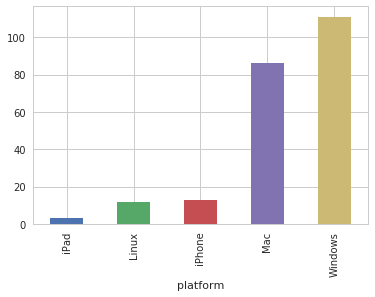

In [27]:
# Display platform distribution

userAgent_count.groupby('platform')['user_counts'].sum().sort_values().plot(kind='bar');

Windows and Chrome are used most often among the users.

In [28]:
# Get time data

time_data = spark.sql('''
        SELECT time,userId
        FROM Sparkify_local_cleaned
''').toPandas()

In [29]:
time_data['time'] = pd.to_datetime(time_data['time'])

In [30]:
# Get weekday, day and hour information

weekday_dict = {0:'Mon.',1:'Tues.',2:'Wed.',3:'Thur.',4:'Fri.',5:'Sat.',6:'Sun.'}
time_data['weekday'] = time_data['time'].dt.weekday.map(weekday_dict)
time_data['day'] = time_data['time'].dt.day
time_data['hour'] = time_data['time'].dt.hour

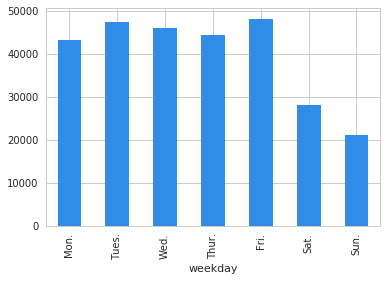

In [31]:
# Display the usage at different weekday

time_data.groupby('weekday')['userId'].count().loc[list(weekday_dict.values())].plot(kind='bar',color='#318ce7');

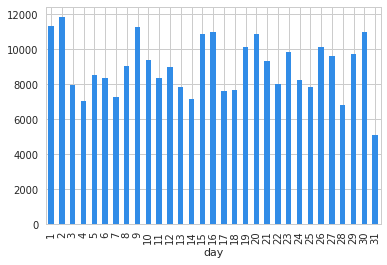

In [32]:
# Display the usage at different days 

time_data.groupby('day')['userId'].count().plot(kind='bar',color='#318ce7');

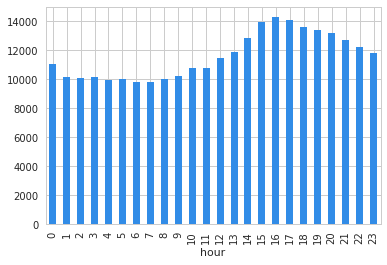

In [33]:
# Display the usage at different hours

time_data.groupby('hour')['userId'].count().plot(kind='bar',color='#318ce7');

Sparkify users are more active in workdays than weekend; In one single day, more active after 14 o'clock.

### Define Churn

Some preliminary analysis has been done above, now the job is to create a column `Churn` to use as the label for the model. The `Cancellation Confirmation` events are used to define churn, which happen for both paid and free users. 

In [34]:
# list all events in the page

df_clean.select('page').dropDuplicates().collect()

[Row(page='Cancel'),
 Row(page='Submit Downgrade'),
 Row(page='Thumbs Down'),
 Row(page='Home'),
 Row(page='Downgrade'),
 Row(page='Roll Advert'),
 Row(page='Logout'),
 Row(page='Save Settings'),
 Row(page='Cancellation Confirmation'),
 Row(page='About'),
 Row(page='Settings'),
 Row(page='Add to Playlist'),
 Row(page='Add Friend'),
 Row(page='NextSong'),
 Row(page='Thumbs Up'),
 Row(page='Help'),
 Row(page='Upgrade'),
 Row(page='Error'),
 Row(page='Submit Upgrade')]

In [35]:
# Define the flag event using cancellation confirmation udf to transform event to 0 or 1

flag_event = udf(lambda x : 1 if x=='Cancellation Confirmation' else 0, IntegerType())

In [36]:
# Define the current churn or not state

df_clean_churn = df_clean.withColumn('Churn_state',flag_event('page'))

In [37]:
# Mark the user who have churned 

userwindow = Window.partitionBy('userId').rangeBetween(Window.unboundedPreceding,Window.unboundedFollowing)
df_clean_churn = df_clean_churn.withColumn('Churn',fmax('Churn_state').over(userwindow))

In [38]:
# check how many users churned and how many not

df_clean_churn.dropDuplicates(['userId']).select('Churn').groupby('Churn').count().collect()

[Row(Churn=1, count=52), Row(Churn=0, count=173)]

There are 52 users churned , it's about 23.1% churned rate. The rate of churn and not churn is roughly 1:3, indicating imbalanced data.

In [39]:
# Check gendar impact

df_clean_churn.dropDuplicates(["userId", "gender"]).groupby(["Churn", "gender"]).count().sort("Churn").show()

+-----+------+-----+
|Churn|gender|count|
+-----+------+-----+
|    0|     M|   89|
|    0|     F|   84|
|    1|     F|   20|
|    1|     M|   32|
+-----+------+-----+



In [40]:
# Perfrom p-value test 

proportions_ztest([32,20],[121,104],alternative='two-sided')

(1.2800974409737422, 0.20051086855629463)

Churn rate is 0.264 in male and 0.192 in females, but the p-value is 0.2 over 0.05, so the gender has almost no effect on Churn or not.

In [41]:
# Define normalization function to prepare for the modeling

def normalize_data(groupby_data):
    groupby_series = groupby_data.set_index(list(groupby_data.columns[:2]))
    temp = groupby_series.unstack('Churn').fillna(0)
    df = pd.DataFrame(((temp - temp.min()) / (temp.max() - temp.min())).stack()).reset_index()
    df = df.rename(columns={df.columns[-1]:'result'})
    return df

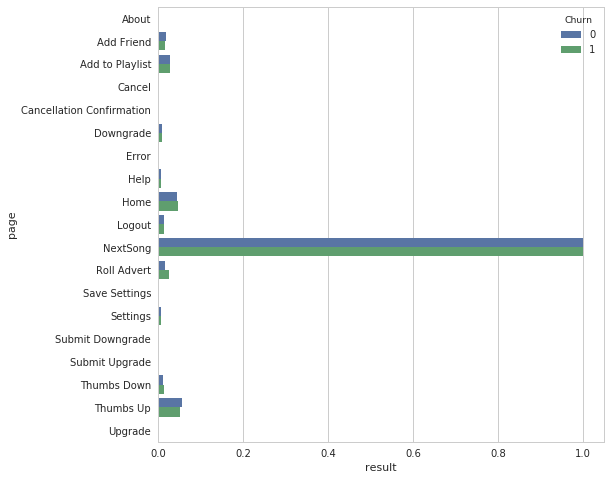

In [42]:
# create page column and display

page_data = df_clean_churn.select(["page","Churn"]).groupby([ "page","Churn"]).count().sort("page").toPandas()
page_data = normalize_data(page_data)
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot( x="result",y="page", hue="Churn", data=page_data,ax=ax);

Roll advert, thumbs down seems has a positive correlation with more Churn event (1), Add friend, Thumbs up seems a negative correlation with more more Churn event (1).

In [43]:
# Get hour/day/weekday information

get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%w'))

In [44]:
# Added them into data column

df_clean_churn = df_clean_churn.withColumn('hour', get_hour(df_clean_churn.ts))
df_clean_churn = df_clean_churn.withColumn('day', get_day(df_clean_churn.ts))
df_clean_churn = df_clean_churn.withColumn('dayofweek', get_weekday(df_clean_churn.ts))

In [45]:
hour_data = df_clean_churn.select(["Churn", "hour"]).groupby(["Churn", "hour"]).count().sort("hour").toPandas()
day_data = df_clean_churn.select(["Churn", "day"]).groupby(["Churn", "day"]).count().sort("day").toPandas()
dayofweek_data = df_clean_churn.select(["Churn", "dayofweek"]).groupby(["Churn", "dayofweek"]).count().sort("dayofweek").toPandas()

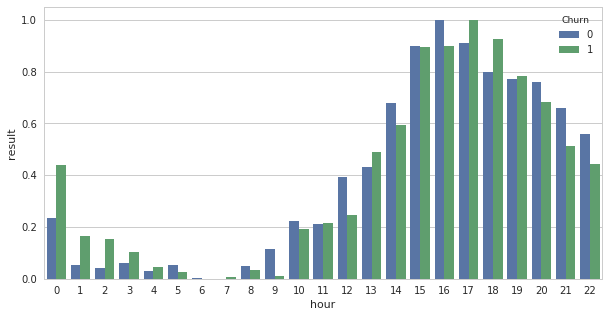

In [46]:
# Display hour distribution

hour_data = normalize_data(hour_data)
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot( x="hour",y="result", hue="Churn", data=hour_data,ax=ax,order=list(map(lambda x: str(x),range(23))));

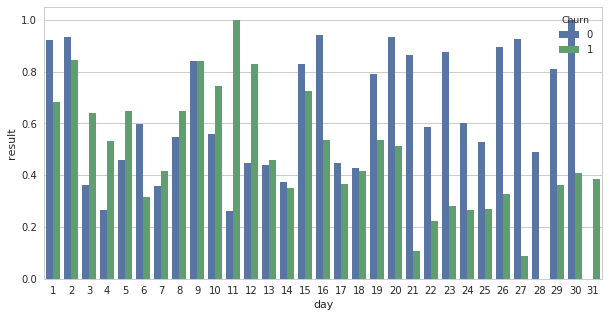

In [47]:
# Display day distribution

day_data = normalize_data(day_data)
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot( x="day",y="result", hue="Churn", data=day_data,ax=ax,order=list(map(lambda x: str(x),range(1,32))));

Significant difference between churned and not churned started around middle of the month

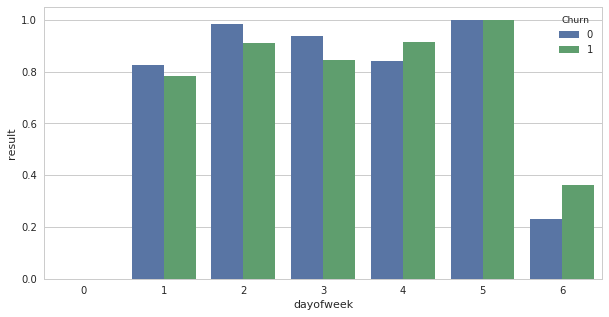

In [48]:
# Display weekday information

dayofweek_data = normalize_data(dayofweek_data)
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot( x="dayofweek",y="result", hue="Churn", data=dayofweek_data,ax=ax);
# Number decoding: start from 0 meaning Monday, end at 6 mean Sunday.

In [49]:
# Get browsers

browser = udf(lambda x : get_browser(x))
df_clean_churn = df_clean_churn.withColumn('browser',browser(df_clean_churn.userAgent))

In [50]:
# Get platform

get_platform = udf(lambda x: platform_dict[re.findall(r'\(([^\)]*)\)',x)[0].split(';')[0]])
df_clean_churn = df_clean_churn.withColumn('platform',get_platform(df_clean_churn.userAgent))

In [51]:
# Normalize and display browser data

browser_data = df_clean_churn.select(["browser","Churn"]).groupby([ "browser","Churn"]).count().sort("browser").toPandas()
browser_data = normalize_data(browser_data)

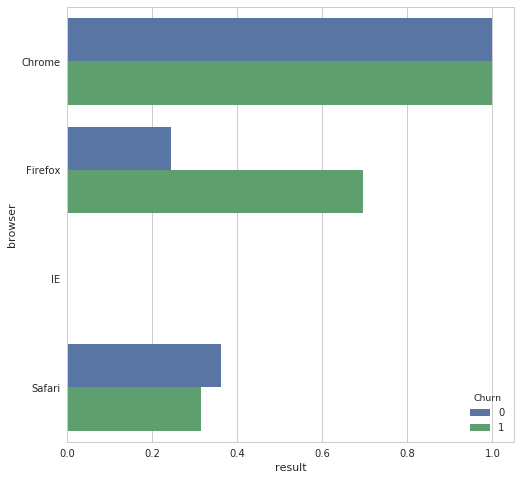

In [52]:
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot( x="result",y="browser", hue="Churn", data=browser_data,ax=ax);

In [53]:
# Normalize platform data

platform_data = df_clean_churn.select(["platform","Churn"]).groupby([ "platform","Churn"]).count().sort("platform").toPandas()
platform_data = normalize_data(platform_data)

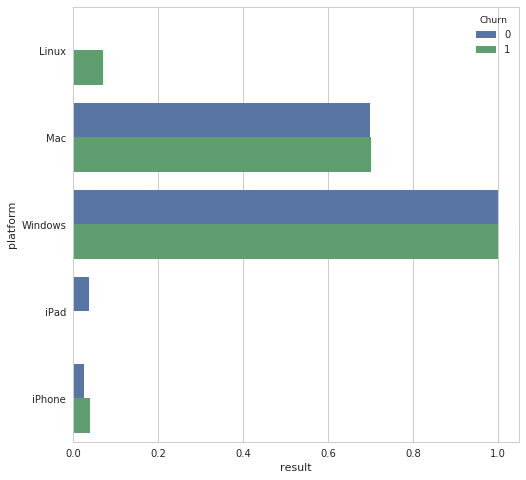

In [54]:
# Display platform data

fig, ax = plt.subplots(figsize=(8,8))
sns.barplot( x="result",y="platform", hue="Churn", data=platform_data,ax=ax);

Interesting correlation of churn or not churn with browsers and platforms, i.e. customers use firefox and linux seems more likely to churn and use ipad seems more likely to stay. Although browsers and platforms may not be direct reasons why customers cancelled the service, their correlation with churn may help for the ML modeling to predict the churn events.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [55]:
df_clean_churn.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- time: string (nullable = true)
 |-- Churn_state: integer (nullable = true)
 |-- Churn: integer (nullable = true)
 |-- hour: string (nullable = true)
 |-- day: string (nullable = true)
 |-- dayofweek: string (nullable = true)
 |-- browser: string (nullable = true)
 |-- platform: string (nullable = tru

### Creating features as below:
- Categorical Features with label encoding applied
    - gender
    - level
    - browser
    - platform
- Numerical Features
    - mean,max,min,std of length of users
    - numbers of relevant events in page (ThumbsUp, ThumbsDown, AddFriend, RollAdvert)
    - number of unique songs and total songs of users
    - number of unique artists of users
    - percentage of operations after 15th of each month
    - percentage of operations in workday

In [56]:
def label_encoding(col_name):
    '''
    transform categorical items to number
    '''
    temp = df_clean_churn.select([col_name]).dropDuplicates().toPandas()

    label_dict = {val:str(idx) for idx,val in enumerate(temp[col_name].tolist())}
    result = df_clean_churn.dropDuplicates(['userId']).select(['userId',col_name]).replace(label_dict,subset=col_name)
    return result

In [57]:
def get_categorical_features():
    '''
    join all categorical features together
    '''
    feature_gender = label_encoding('gender')
    feature_level = label_encoding('level')
    feature_browser = label_encoding('browser')
    feature_platform = label_encoding('platform')
    
    result = feature_gender.join(feature_level,on='userId',how='inner').\
                            join(feature_browser,on='userId',how='inner').\
                            join(feature_platform,on='userId',how='inner')
    return result

In [58]:
# Get label encoded categorical features

categorical_feature = get_categorical_features()

In [59]:
categorical_feature.show(5)

+------+------+-----+-------+--------+
|userId|gender|level|browser|platform|
+------+------+-----+-------+--------+
|100010|     0|    0|      1|       1|
|200002|     1|    0|      1|       1|
|   125|     1|    0|      3|       3|
|   124|     0|    1|      3|       3|
|    51|     1|    1|      3|       4|
+------+------+-----+-------+--------+
only showing top 5 rows



In [60]:
def get_numerical_features():
    '''
    join all numerical features together and implement Standscaler
    '''
    #length
    feature_length = df_clean_churn.select(["userId", "length"]).groupby(["userId"]).agg(avg('length').alias('mean_length'), 
                                                                     stddev('length').alias('stdev_length'),
                                                                    fmax('length').alias('max_length'),
                                                                    fmin('length').alias('min_length'))
    
   
    page_count = df_clean_churn.select(["userId","page"]).groupby(["userId","page"]).count()
    
    # create the pivot table
    temp1 = page_count.groupby('userId').pivot('page').agg(first('count')).fillna(0)
    
    # filter columns
    temp1 = temp1.select(['userId','Thumbs Up', 'Thumbs Down',  'Add Friend', 'Roll Advert'])
    
    # column names used to sum up for total
    cols = temp1.columns[1:]
    
    # calculate the total 
    feature_page = temp1.withColumn('total', sum([col(c) for c in cols]))    
    
    
    #unique songs number
    feature_nunique_song = df_clean_churn.filter(df_clean_churn.page=='NextSong').select(["userId","song"]).\
                                             dropDuplicates(["userId","song"]).groupby(["userId"]).count()
    feature_nunique_song = feature_nunique_song.selectExpr("userId as userId","count as nunique_song")
    
    #total songs number
    feature_ntotal_song = df_clean_churn.filter(df_clean_churn.page=='NextSong').select(["userId","song"]).\
                                             groupby(["userId"]).count()
    #source:https://exceptionshub.com/how-to-change-dataframe-column-names-in-pyspark.html
    feature_ntotal_song = feature_ntotal_song.selectExpr("userId as userId","count as ntotal_song")
    
    #unique artists artist
    feature_nunique_artist = df_clean_churn.filter(df_clean_churn.page=='NextSong').select(["userId","artist"]).\
                                               dropDuplicates(["userId","artist"]).groupby(["userId"]).count()
    feature_nunique_artist = feature_nunique_artist.selectExpr("userId as userId","count as nunique_artist")
    
    #percentage of opretions
    day_count = df_clean_churn.filter(df_clean_churn.day>=15).select(['userId']).groupby(["userId"]).count()
    day_count = day_count.selectExpr("userId as userId","count as day_count")
    
    total_count = df_clean_churn.select(['userId']).groupby(["userId"]).count()
    total_count = total_count.selectExpr("userId as userId","count as total_count")
    
    dayofweek_count = df_clean_churn.filter(df_clean_churn.dayofweek<5).select(['userId']).groupby(["userId"]).count()
    dayofweek_count = dayofweek_count.selectExpr("userId as userId","count as dayofweek_count")
    
    feature_percentage_month = (total_count.alias("total").join(day_count.alias("day"), ["userId"]).\
                              select(col("userId"), (col("day.day_count") / col("total.total_count")).alias("month_percentage")))
    
    feature_percentage_week = (total_count.alias("total").join(dayofweek_count.alias("day"), ["userId"]).\
                          select(col("userId"), (col("day.dayofweek_count") / col("total.total_count")).alias("week_percentage")))
    
    #merge together
    result = feature_length.join(feature_page,on='userId',how='inner').\
                        join(feature_nunique_song,on='userId',how='inner').\
                        join(feature_ntotal_song,on='userId',how='inner').\
                        join(feature_nunique_artist,on='userId',how='inner').\
                        join(feature_percentage_month,on='userId',how='inner').\
                        join(feature_percentage_week,on='userId',how='inner')
    
    return result

In [61]:
# create lables

label = df_clean_churn.select(['userId','Churn']).dropDuplicates()

In [62]:
def get_data_for_train():
    '''
    merge features and label together
    '''
    categorical_feature = get_categorical_features()
    numerical_feature = get_numerical_features()
    label = df_clean_churn.select(['userId','Churn']).dropDuplicates()
    result = categorical_feature.join(numerical_feature,on='userId',how='inner').join(label,on='userId',how='inner')
    
    #correct datatype
    for col_name in result.columns[1:5]:
        result = result.withColumn(col_name, result[col_name].cast(IntegerType()))
    for col_name in result.columns[5:-1]:
        result = result.withColumn(col_name, result[col_name].cast(FloatType()))
    
    #fill NaN
    result = result.na.fill(0)
    
  
    return result

In [63]:
# create training data

final_data = get_data_for_train()    

In [64]:
# remove the label columns

final_data_columns = final_data.columns
final_data_columns.remove('Churn')
final_data_columns.remove('userId')

In [65]:
categorical_features = ['gender','level','browser','platform']
numerical_features = [col_name for col_name in final_data_columns if col_name not in categorical_features]

In [66]:
check_df = final_data.toPandas()

In [67]:
# Display the statistics of the training datasets input 

check_df.describe()

,gender,level,browser,platform,mean_length,stdev_length,max_length,min_length,Thumbs Up,Thumbs Down,Add Friend,Roll Advert,total,nunique_song,ntotal_song,nunique_artist,month_percentage,week_percentage,Churn
count,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000
mean,0.529412,0.210784,1.916667,3.294118,249.053497,95.958961,1295.913940,35.869896,60.544117,12.294118,20.524509,18.789215,112.151962,971.705872,1098.950928,751.343140,0.569815,0.717050,0.186275
std,0.500362,0.408869,1.258632,0.899789,5.172367,16.822758,715.580505,29.162518,66.867363,13.325474,20.971113,22.169514,105.845139,906.773743,1123.814697,604.887939,0.230926,0.210211,0.390286
min,0.000000,0.000000,0.000000,0.000000,230.556274,37.977070,272.195465,0.783220,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,3.000000,3.000000,0.044118,0.044118,0.000000
25%,0.000000,0.000000,1.000000,3.000000,246.827190,86.072651,710.980789,18.050159,15.500000,3.000000,7.000000,3.750000,40.000000,257.500000,263.750000,247.000000,0.403112,0.593916,0.000000
50%,1.000000,0.000000,3.000000,3.000000,248.980064,92.904976,1079.535828,26.970975,40.500000,9.000000,16.000000,11.500000,85.500000,714.000000,753.000000,603.500000,0.579770,0.734580,0.000000
75%,1.000000,0.000000,3.000000,4.000000,251.089756,102.562956,1670.451782,43.447706,84.000000,17.000000,28.000000,24.250000,149.500000,1449.250000,1626.500000,1122.000000,0.742573,0.901531,0.000000
max,1.000000,1.000000,3.000000,4.000000,267.767151,178.539139,3024.665771,197.824844,437.000000,75.000000,143.000000,128.000000,707.000000,5946.000000,8002.000000,3544.000000,1.000000,1.000000,1.000000


In [68]:
# Apply standscaler

vector = VectorAssembler(inputCols=numerical_features, outputCol='numerical_features')
temp = vector.transform(final_data)
scaler = StandardScaler(withMean=True, withStd=True, inputCol='numerical_features', outputCol='features_scaled')
scaler_fit = scaler.fit(temp)
result_scaled = scaler_fit.transform(temp)

# Add categorical features to training data input

vector = VectorAssembler(inputCols=categorical_features+['features_scaled'], outputCol='all_features')
result_scaled = vector.transform(result_scaled)
final_result = result_scaled.select(result_scaled.Churn.alias('label'), result_scaled.all_features.alias('features'))

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [69]:
def undersample(df): 
    '''
    Implement undersample on dataset, return a balanced dataset.
    '''    
    # size of minority class(0)
    minoritySize = df.where(df.label == '1').count()
    
    # two classes with the same size
    df_minority = df.where(df.label == '1')
    df_majority = df.where(df.label == '0').sample(1.0, seed=12).limit(minoritySize)
    
    # concatenate them together
    result = df_minority.union(df_majority)
    
    #shuffle data
    result = result.orderBy(rand())
    return result

In [70]:
# Fix the data imbalance issue

balanced_data = undersample(final_result)

In [71]:
check_balanced_df = balanced_data.toPandas()

In [72]:
# Check out balance
balanced_data.groupby(balanced_data.label).count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|   38|
|    0|   38|
+-----+-----+



In [73]:
# Split the total training datasets to 0.7 for training and 0.3 for testing

train, test = balanced_data.randomSplit([0.7, 0.3], seed=12)

In [74]:
test.count()

21

Following models are trained and tested: Logistic Regression, Decision Tree, Random Forest Classifier and LinearSVC.

In [75]:
# Initialize four models

clf_LR = LogisticRegression(maxIter=50)
clf_DT = DecisionTreeClassifier(seed=12)
clf_RF = RandomForestClassifier(seed=12)
clf_SVM = LinearSVC() 

In [76]:
# Evaluate the results

evaluator= MulticlassClassificationEvaluator(predictionCol="prediction")

In [77]:
# Collect results on the learners

all_results = {}
for clf in [clf_LR, clf_DT, clf_RF, clf_SVM]:
    model_results = {}
    # get the classifier name
    clf_name = clf.__class__.__name__
    
    
    # fit the dataset
    print(f'{clf_name} is training...')
    start = time.time() 
    model = clf.fit(train)
    end = time.time() 
    model_results['train_time'] = round(end-start,6)
    
    # predict
    print(f'{clf_name} is predicting...')
    start = time.time() 
    pred_test = model.transform(test)
    end = time.time()
    model_results['pred_time'] = round(end-start,6)
    
    #metrics
    print(f'{clf_name} is evaluating...')    
    model_results['f1_test'] = evaluator.evaluate(pred_test.select('label','prediction'),{evaluator.metricName: 'f1'})
    print('Test F1-score: ',model_results['f1_test'])
    all_results[clf_name] = model_results
    
all_results_df = pd.DataFrame(all_results)


LogisticRegression is training...
LogisticRegression is predicting...
LogisticRegression is evaluating...
Test F1-score:  0.6190476190476191
DecisionTreeClassifier is training...
DecisionTreeClassifier is predicting...
DecisionTreeClassifier is evaluating...
Test F1-score:  0.3401680672268908
RandomForestClassifier is training...
RandomForestClassifier is predicting...
RandomForestClassifier is evaluating...
Test F1-score:  0.380952380952381
LinearSVC is training...
LinearSVC is predicting...
LinearSVC is evaluating...
Test F1-score:  0.6681922196796338


In [78]:
all_results_df

,LogisticRegression,DecisionTreeClassifier,RandomForestClassifier,LinearSVC
f1_test,0.619048,0.340168,0.380952,0.668192
pred_time,0.142385,0.145375,0.235283,0.138605
train_time,272.270314,209.463848,218.025425,2264.943121


### Conclusion

The Linear SVC has the highest f1 score 0.67 comapred to Logistic Regression, Decision Tree and Random Forest classifier. The Linear SVC also has the longest training time, almost 10 times than other methods. Logistic Regression may win if both the f1 score and optimized training time are considered, as the f1 score from the Logistic Regression 0.62 is just 0.05 less than Linear SVC, but 9 times faster. 

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.